Importing all the required Libraries

In [1]:
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import matplotlib
from scipy.sparse import coo_matrix, hstack
from scipy import sparse
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

### 1: Loading the train data and test data from csv files

In [2]:
# loading the data
data_set = pd.read_csv('./data/other/tweeter-comments-csv.csv')

In [3]:
data_set.head()

,comment_text,hate_speech,offensive_language,neither
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,3
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0,3,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0,3,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0,2,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0,6,0


Utility classes/functions to extract/prepare the data set

In [4]:
# PrepareData
class PrepareData:
    """
    Class to perpare the data for taraining, and testing 
    The class provide instance and static methods to prepare the data.

    Args:
    data_set : data set
    """

    # get and initialize the dataset
    def __init__(self, data_set):
        self.data_set = data_set

    def split_data(self, train_percent=.7, test_percent=.3, seed=None):
        """ This method split the data into train data set and test data set
        by default it splits the data as train_data = 70% and test_data = 30%

        Args:
        train_percent : percentage of train data, default value - 0.7
                        default:0.7
        test_pecent : percetage of test data, default value - 0.3
                        default:0.3
        seed : None optional

        Returns:
        train_data : tranin data
        test_data : test data
        """

        np.random.seed(seed=seed)
        permuted_test = np.random.permutation(self.data_set.index)
        total_len = len(data_set.index)
        train_end = int(train_percent * total_len)
        test_end = int(test_percent * total_len) + train_end
        train_data = self.data_set.loc[permuted_test[:train_end]]
        test_data = self.data_set.loc[permuted_test[train_end:test_end]]

        return train_data, test_data

    @staticmethod
    def prepare_test_data(labels, data_set):
        """
        Utility method to prepare the test data. 
        This method keeps the lables which are required for testing 
        by removing other lables from data frame

        Args:
        labels : list of expected lables in test data set
        data_set : test data set

        Returns:
        data_set : processed dataset
        """

        deleting_labels = [label for label in list(
            data_set.columns) if label not in labels]
        data_set = data_set.drop(deleting_labels, axis=1)
        return data_set

split the data set into train data and test data

In [5]:
prepare_data = PrepareData(data_set)
train_data, test_data = prepare_data.split_data()

Looking at the data set before pre processing.

In [6]:
# size of traning and test data sets
len(train_data), len(test_data)

(17348, 7434)

In [7]:
train_data.head()

,comment_text,hate_speech,offensive_language,neither
19653,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,3
4896,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0,3,0
16931,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0,3,0
8199,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0,2,1
2185,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0,6,0


In [8]:
test_data.head()

,comment_text,hate_speech,offensive_language,neither
1650,RT @Smooth_Orator: For niggas who claim to lov...,0,3,0
12800,RT @Smooth_Orator: Slander don't exist when yo...,0,2,1
16187,RT @Smug_Lemur: He loves me *eats a brownie* \...,0,0,3
20972,RT @SnapBackTC: wake me up when da bitches get...,0,3,0
5701,RT @Sneakbo: Man like @Stormzy1 doing Hella th...,1,2,0


In [9]:
train_data.describe()

,hate_speech,offensive_language,neither
count,17348.000000,17348.000000,17348.000000
mean,0.296634,2.386500,0.550899
std,0.654438,1.383919,1.116649
min,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000
50%,0.000000,3.000000,0.000000
75%,0.000000,3.000000,0.000000
max,7.000000,9.000000,9.000000


In [10]:
# Global variables
LABELS = list(train_data.columns)  # getting all columns
CLASS_LABELS = LABELS[1:]  # selecting only classes
CLASS_LABELS

['hate_speech', 'offensive_language', 'neither']

The training data set is multi-labeled, which means each comment is labeled with one or more classes. So, it is better to have an idea about the number of comments fall in each classes.



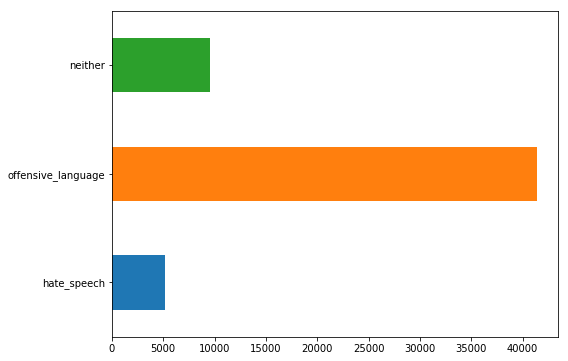

In [11]:
train_class_count = train_data[CLASS_LABELS].sum()
# print(train_class_count)
train_class_count.plot.barh(figsize=(8, 6))

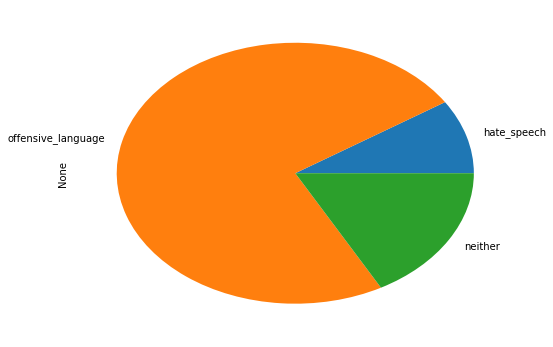

In [12]:
train_class_count.plot.pie(figsize=(8, 6))

Total number of characters -  1479276
Longest comment length -  657
Shortest comment length -  7


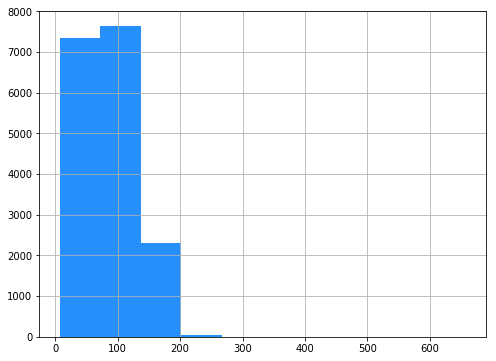

In [13]:
train_tmp_df = train_data
train_tmp_df['comment_length'] = train_tmp_df['comment_text'].apply(
    lambda y: len(str(y)))
print("Total number of characters - ", train_tmp_df['comment_length'].sum())
print("Longest comment length - ", train_tmp_df['comment_length'].max())
print("Shortest comment length - ", train_tmp_df['comment_length'].min())

train_tmp_df['comment_length'].hist(color='#258ffc', figsize=(8, 6))

To compare the train data and test data with respect to the length of comment and its distribution, will perform similar operations on test data set.

Total number of characters -  637959
Longest comment length -  754
Shortest comment length -  5


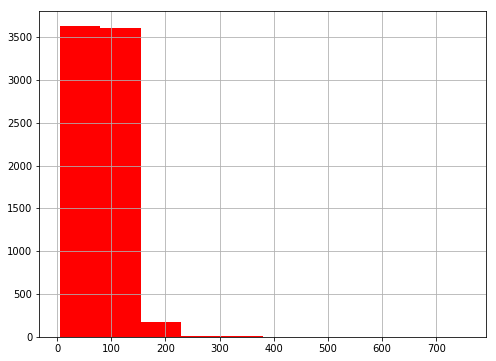

In [14]:
test_tmp_df = test_data
test_tmp_df['comment_length'] = test_tmp_df['comment_text'].apply(
    lambda t: len(str(t)))
print("Total number of characters - ", test_tmp_df['comment_length'].sum())
print("Longest comment length - ", test_tmp_df['comment_length'].max())
print("Shortest comment length - ", test_tmp_df['comment_length'].min())

test_tmp_df['comment_length'].hist(color='red', figsize=(8, 6))

Now, the shape of comment and its length distribution looks similar between the training data and the train data. Next step is clean the data.

### 2. Cleaning the train and test data

In [15]:
class CleanData:
    """
    Utiliy class to clean the data. provides instance and static methods 
    for cleaning the train/test data

    Args:
    data_set : data set to be cleaned. 
    """

    def __init__(self, data_set):
        self.data_set = data_set

    def fill_null(self):
        """
        Method to fill all the null values in the data set

        Args:

        Returns:
        data_set : data set with non null values

        """
        self.data_set.fillna(' ')
        return self.data_set

    def clean_text(self, field):
        """
        Method to clean the text data. 

        Args:
        field : class label in the data set

        Returns:
        data_set : cleaned data set

        """
        self.data_set[field] = self.data_set[field].str.replace(r"http\S+", "")
        self.data_set[field] = self.data_set[field].str.replace(r"http", "")
        self.data_set[field] = self.data_set[field].str.replace(r"@\S+", "")
        self.data_set[field] = self.data_set[field].str.replace(r"!+ RT", "")
        self.data_set[field] = self.data_set[field].str.replace(r"RT ", "")
        self.data_set[field] = self.data_set[field].str.replace(
            r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
        self.data_set[field] = self.data_set[field].str.replace(r"@[a-zA-Z0-9_]", " ")
        self.data_set[field] = self.data_set[field].str.replace(
            r"what's", "what is")
        self.data_set[field] = self.data_set[field].str.replace(
            r"\'ve", " have")
        self.data_set[field] = self.data_set[field].str.replace(
            r"can't", "can not")
        self.data_set[field] = self.data_set[field].str.replace(
            r"don't", "do not")
        self.data_set[field] = self.data_set[field].str.replace(
            r"weren't", "were not")
        self.data_set[field] = self.data_set[field].str.replace(
            r"doesn't", "does not")
        self.data_set[field] = self.data_set[field].str.replace(
            r"i'm", "i am ")
        self.data_set[field] = self.data_set[field].str.replace(
            r"\'re", " are ")
        self.data_set[field] = self.data_set[field].str.replace(
            r"\'d", " would ")
        self.data_set[field] = self.data_set[field].str.replace(
            r"shouldn't", " should not ")
        self.data_set[field] = self.data_set[field].str.replace(r"\'s", " ")
        self.data_set[field] = self.data_set[field].str.replace(r"\W", " ")
        self.data_set[field] = self.data_set[field].str.replace(r"\s+", " ")
        self.data_set[field] = self.data_set[field].str.lower()
        return self.data_set

    def remove_stop_words(self, field):
        """
        Method to remove the stopwords from the text.

        Args:
        field: class label in the dataset

        Returns:
        data_set : data set without stopwords.
        """
        self.data_set[field].apply(lambda x: ' '.join(
            [word for word in x.split() if word not in stopwords.words('english')]))
        return self.data_set

    def get_text(self, field):
        """
        Utility method to get particular column from data set

        Args:
        field : name of the required field

        Returns:
        data_set : returns the text of metioned field
        """

        return self.data_set[field]

    @staticmethod
    def get_all_text(data_set_one, data_set_two, field):
        """
        Static method to combine a particular column of two data sets.

        Args:
        data_set_one : data frame 
        data_set_two : data frame
        field : column name 

        Returns:
        data_set : new data set

        """
        data_set = pd.concat([data_set_one[field], data_set_two[field]])
        return data_set

    @staticmethod
    def get_all_text(data_set_one, data_set_two):
        """
        Static method to combine two data sets.

        Args:
        data_set_one : first data set of type data frame
        data_set_two : second data set of type 

        Returns:
        data_set_merged : new combined data set
        """
        data_set_merged = pd.concat([data_set_one, data_set_two])
        return data_set_merged

The above class CleanData provides couple of methods to perform the data cleaning both on train and test data.CleanData class also defined some static methods to combine the data sets.

Cleaning the train and test data

In [16]:
clean_train_data = CleanData(train_data)
train_text = clean_train_data.fill_null()
train_text = clean_train_data.clean_text(field='comment_text')
train_text = clean_train_data.remove_stop_words(field='comment_text')
train_text = clean_train_data.get_text('comment_text')
train_text.head()

19653     as a woman you should not complain about clea...
4896      boy dats cold tyga dwn bad for cuffin dat hoe...
16931     dawg you ever fuck a bitch and she start to c...
8199                                she look like a tranny
2185      the shit you hear about me might be true or i...
Name: comment_text, dtype: object

In [17]:
train_text.shape, type(train_text)

((17348,), pandas.core.series.Series)

In [18]:
train_text.head()

19653     as a woman you should not complain about clea...
4896      boy dats cold tyga dwn bad for cuffin dat hoe...
16931     dawg you ever fuck a bitch and she start to c...
8199                                she look like a tranny
2185      the shit you hear about me might be true or i...
Name: comment_text, dtype: object

In [19]:
clean_test_data = CleanData(test_data)
test_text = clean_test_data.fill_null()
test_text = clean_test_data.clean_text(field='comment_text')
test_text = clean_test_data.remove_stop_words(field='comment_text')
test_text = clean_test_data.get_text('comment_text')
test_text.head()

1650      for niggas who claim to love pussy as much as...
12800     slander do not exist when you make her cum ev...
16187     he loves me eats a brownie he loves me not ea...
20972                  wake me up when da bitches get here
5701      man like doing hella things 128175 128175 128...
Name: comment_text, dtype: object

In [20]:
test_text.shape, type(test_text)

((7434,), pandas.core.series.Series)

In [21]:
test_text.head()

1650      for niggas who claim to love pussy as much as...
12800     slander do not exist when you make her cum ev...
16187     he loves me eats a brownie he loves me not ea...
20972                  wake me up when da bitches get here
5701      man like doing hella things 128175 128175 128...
Name: comment_text, dtype: object

In [22]:
full_text = CleanData.get_all_text(
    data_set_one=train_text, data_set_two=test_text)

### 3. Feature Implementation, Build and Train Model

In [23]:
class WordVectorizer:
    """
    WordVectorizer class provides methods to perform vectorization for words

    Args:
    data_set : input data set

    """

    def __init__(self, data_set):
        self.data_set = data_set

    def word_vector(self, ngram_value=1):
        """

        word_vector method generates the Tfidf vector for the data set. 
        It accepts an optinal parameter to specify the ngram value.

        Args:
        ngram_value : n gram value, default:1.

        Returns:
        word_vec : Tfidf vector.

        """
        word_vec = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode',
                                   analyzer='word', token_pattern=r'\w{1,}',
                                   stop_words='english', ngram_range=(1, ngram_value),
                                   max_features=10000)
        word_vec.fit(self.data_set)
        return word_vec

Above class provides method to get the trem documents for words. Also, implemented ngram feature before Tfidf vectorization. We can dynamically specify the ngram feature to its method.

In [24]:
class CharVectorizer:
    """
    CharVectorizer class provides methods to perform character level ngram and Tfidf.

    Args:
    data_set : input data set

    """

    def __init__(self, data_set):
        self.data_set = data_set

    def char_vector(self):
        """
        char_vector method generates the Tfidf vector for the data set. 

        Returns:
        char_vec : Tfidf vector.

        """

        char_vec = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode',
                                   analyzer='char', stop_words='english',
                                   ngram_range=(4, 6), max_features=50000)
        char_vec.fit(self.data_set)
        return char_vec

The above class is to implement the character level n-gram and then generate the term frequency vector. This help to find out the hidden toxic characters or group of characters which are usually found within a word.

In [25]:
# word_vectorizer = WordVectorizer(full_text)
word_vectorizer = WordVectorizer(train_text)
word_vec = word_vectorizer.word_vector()

In [26]:
train_word_features = word_vec.transform(train_text)

In [27]:
test_word_features = word_vec.transform(test_text)

In [28]:
# char_vectorizer = CharVectorizer(full_text)
char_vectorizer = CharVectorizer(train_text)
char_vec = char_vectorizer.char_vector()
train_char_features = char_vec.transform(train_text)
test_char_features = char_vec.transform(test_text)

In [29]:
train_target = CleanData(train_data).fill_null()
train_target = CleanData(train_data).clean_text(field='comment_text')
train_target = CleanData(train_data).remove_stop_words(field='comment_text')
train_features = hstack([train_char_features, train_word_features])
type(train_target), type(train_features)

(pandas.core.frame.DataFrame, scipy.sparse.coo.coo_matrix)

In [30]:
train_target.head()

,comment_text,hate_speech,offensive_language,neither,comment_length
19653,as a woman you should not complain about clea...,0,0,3,140
4896,boy dats cold tyga dwn bad for cuffin dat hoe...,0,3,0,85
16931,dawg you ever fuck a bitch and she start to c...,0,3,0,120
8199,she look like a tranny,0,2,1,62
2185,the shit you hear about me might be true or i...,0,6,0,137


In [31]:
full_text = CleanData.get_all_text(
    data_set_one=train_text, data_set_two=test_text)

In [32]:
train_target.shape, train_features.shape,train_char_features.shape

((17348, 5), (17348, 60000), (17348, 50000))

In [33]:
# combine both char level features and word level features
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])
train_features.shape

(17348, 60000)

In [34]:
test_features.shape
type(test_features)

scipy.sparse.coo.coo_matrix

Defining the classifier Logestic Regression with Naive Bayes features.

In [35]:
class NbLogRegClassifier(BaseEstimator, ClassifierMixin):

    """
    The Logestic Regression classifier makes use of basic Naive Bayes feature.
    The classifier inherits from BaseEstimator and ClassifierMixin sklearn's base package.

    Args:
    C :  Inverse of regularization strength; must be a positive float. 
        Like in support vector machines, smaller values specify stronger regularization.
        default: 1.0
    solver : Algorithm to use in the optimization problem.
            default: 'sag'
            prefered for multiclass problem - 'newton-cg’, ‘sag’, ‘saga’ or ‘lbfgs'
    n_jobs : Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”.
            default: -1 (using all processors)
    max_iter : Maximum number of iterations taken for the solvers to converge.
            default: 4000
    dual: Dual or primal formulation. Dual formulation is only implemented for l2 penalty with liblinear solver. 
          Prefer dual=False when n_samples > n_features.
          default: False

    """

    def __init__(self, C=4, dual=False, n_jobs=-1, solver='sag', max_iter=4000):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs
        self.max_iter = max_iter
        self.solver = solver

    def predict(self, X):
        """

        Predict class labels for samples in X.

        Args:
        X : array_like or sparse matrix, shape (n_samples, n_features)

        Returns:

        C : array, shape [n_samples]
            Predicted class label per sample.

        """
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(X.multiply(self._r))

    def predict_proba(self, X):
        """

        Probability estimates.

        The returned estimates for all classes are ordered by the
        label of classes.

        Args:
        X : array-like, shape = [n_samples, n_features]

        Returns:
        T : 

        """

        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(X.multiply(self._r))

    def fit(self, X, y):
        """

        Fit the model according to the given training data.

        Args:
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and n_features is the number of features.
        y : array-like, shape (n_samples,) or (n_samples, n_targets)
            Target vector relative to X.
        sample_weight : array-like, shape (n_samples,) optional
                        Array of weights that are assigned to individual samples. 
                        If not provided, then each sample is given unit weight.

        Returns:
        self : object

        """

        y = y.values
        X, y = check_X_y(X, y, accept_sparse=True)

        def pr(X, y_i, y):
            """
            Method to implement the basic Naive Bayes feature
            """
            p = X[y == y_i].sum(0)
            return (p+1) / ((y == y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(X, 1, y) / pr(X, 0, y)))
        x_nb = X.multiply(self._r)
        self._clf = LogisticRegression(
            C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

A miscellanious utility class.

In [36]:
class Utility:

    """
    The utility class which provides static methods to perform some miscellanious operations.
    """

    @staticmethod
    def compare_models(md1_acc, md1_name, md2_acc, md2_name, title=None):
        """
        Static method takes the accuracy/cv score of two models and generate comparision graph

        Args:
        md1_acc : Accuracy score/ CV score of model 1, preferred- pandas Series
        md1_name : Name for the first model
        md2_acc : Accuracy score/ CV score of model 1, preferred- pandas Series
        md2_name : Name for the first model
        title : (optional) Title for the comparision.

        Returns: my_plot of type matplotlib's pyplot.
        """

        md1_acc = md1_acc.mul(100, axis=0)
        md2_acc = md2_acc.mul(100, axis=0)
        df = pd.DataFrame(md1_acc, columns=[md1_name])
        df[md2_name] = md2_acc
        my_plot = df.plot(kind='bar', figsize=(12, 10),
                          legend=True, grid=True, title=title, stacked=False)
        my_plot.set_xlabel("Classes")
        my_plot.set_ylabel("Accuracy")
        return my_plot

### 4. Validating the Model

Will train and validate the model.

Naive Bayes

In [38]:
nb_accuracy = {}
for label in CLASS_LABELS:
    train_target = CleanData(train_data).fill_null()
    train_target = train_target[label]
    nb = MultinomialNB()

    cv_score = np.mean(cross_val_score(nb, train_features,
                                       train_target, cv=3))
    nb_accuracy[label] = cv_score

nb_accuracy['mdl_accuracy'] = np.mean(list(nb_accuracy.values()))
print('CV score using Naive Bayes - {}'.format(np.mean(list(nb_accuracy.values()))))


CV score using Naive Bayes - 0.7360911539312952


Text(0,0.5,'Accuracy')

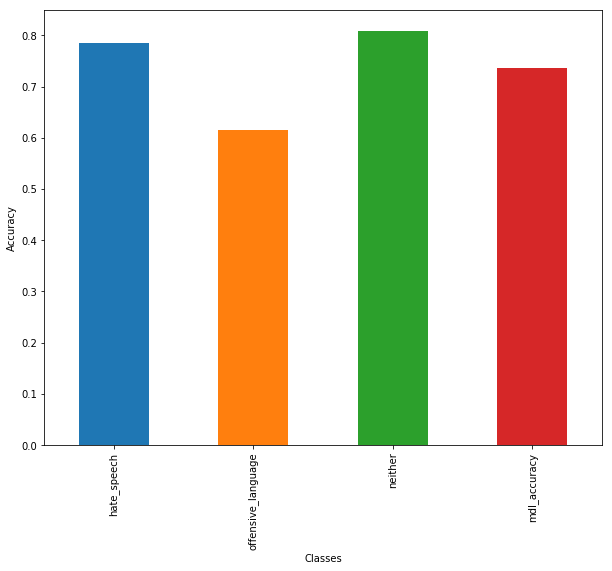

In [39]:
nb_accuracy = pd.Series(nb_accuracy)
my_plot = nb_accuracy.plot(kind='bar', figsize=(10, 8))
my_plot.set_xlabel("Classes")
my_plot.set_ylabel("Accuracy")

Logestic Regression with simple Naive Bayes feature

In [40]:
nb_logreg_accuracy = {}
for label in CLASS_LABELS:
    train_target = CleanData(train_data).fill_null()
    train_target = train_target[label]
    nb_logreg = NbLogRegClassifier(C=4, dual=False, n_jobs=-1, solver='sag', max_iter=2000)

    cv_score = np.mean(cross_val_score(nb_logreg, train_features,
                                       train_target, cv=3))
    nb_logreg_accuracy[label] = cv_score

nb_logreg_accuracy['mdl_accuracy'] = np.mean(list(nb_logreg_accuracy.values()))
print('CV score for NbLogReg - {}'.format(np.mean(list(nb_logreg_accuracy.values()))))


CV score for NbLogReg - 0.7511740647877866


Text(0,0.5,'Accuracy')

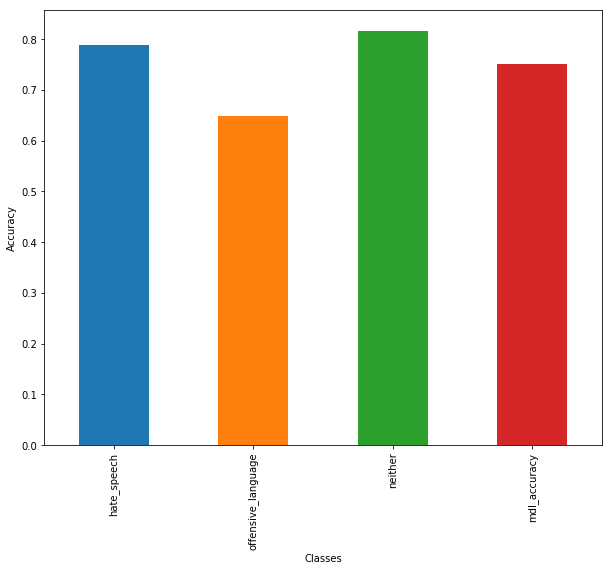

In [41]:
nb_logreg_accuracy = pd.Series(nb_logreg_accuracy)
my_plot = nb_logreg_accuracy.plot(kind='bar', figsize=(10, 8))
my_plot.set_xlabel("Classes")
my_plot.set_ylabel("Accuracy")

Comparing both the models

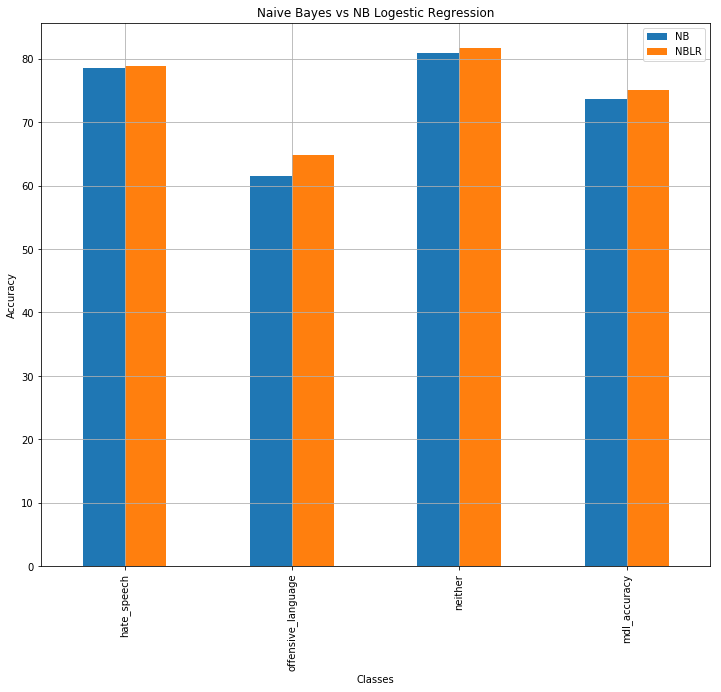

In [42]:
Utility.compare_models(md1_acc=nb_accuracy,md1_name="NB", md2_acc=nb_logreg_accuracy, md2_name="NBLR",title="Naive Bayes vs NB Logestic Regression")